# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from collections import Counter
from statsmodels.tools.eval_measures import rmse

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Read data

## Dataset columns description: 


**id:** id of property </br>
**type:** 
- br - bedroom(s);
- h - house,cottage,villa, semi,terrace;
- u - unit, duplex;
- t - townhouse;
- dev site - development site;
- o res - other residential. 

**yearbuilt:** Year the house was built </br>
**landsize:** Land Size in Metres </br>
**buildingarea:** Building Size in Metres </br>
**rooms:** Number of rooms </br>
**bedroom_alt:** Scraped # of Bedrooms (from different source) </br>
**bathroom:** Number of Bathrooms </br>
**car:** Number of parking spots for cars </br>
**regionname:** General Region (West, North West, North, North east …etc) </br>
**councilarea:** Governing council for the area </br>
**suburb:** Suburb </br>
**address:** Address </br>
**postcode:** Postcode </br>
**distancecbd:** Distance to the nearest Central Business District in Kilometres </br>
**propertycount:** Number of properties that exist in the suburb. </br>
**lattitude:** Lattitude </br>
**longtitude:** Longtitude </br>
**price:** Price - **value to predict**


## Train set

In [2]:
df_train = pd.read_csv("./data/train.csv")
df_train.head(5)

id type  yearbuilt  landsize  buildingarea  rooms  bedroom_alt  \
0   2390    h        NaN     384.0           NaN      4          4.0   
1  33082    h        NaN     614.0           NaN      5          5.0   
2  31328    h     1955.0     630.0         158.0      4          4.0   
3    154    h        NaN     129.0           NaN      3          3.0   
4  15867    h     1950.0     673.0         101.0      3          3.0   

   bathroom  car                  regionname                councilarea  \
0       1.0  1.0       Northern Metropolitan      Moreland City Council   
1       4.0  5.0       Southern Metropolitan       Bayside City Council   
2       1.0  2.0  South-Eastern Metropolitan     Frankston City Council   
3       1.0  0.0       Southern Metropolitan  Port Phillip City Council   
4       1.0  2.0  South-Eastern Metropolitan      Kingston City Council   

           suburb           address  postcode  distancecbd  propertycount  \
0  Brunswick West    29 Grantham St    3055.0          5.9         7082.0   
1        Brighton       27 Foote St    3186.0         10.5        10579.0   
2         Seaford     19 Luxton Tce    3198.0         35.4         8077.0   
3     Albert Park  31 Richardson St    3206.0          3.3         3280.0   
4  Oakleigh South  36 Bossington St    3167.0         15.5         3692.0   

   lattitude  longtitude      price  
0  -37.77330   144.94910   988000.0  
1  -37.89359   144.99360  5250000.0  
2  -38.09840   145.12932   800000.0  
3  -37.84220   144.94900  1300000.0  
4  -37.91693   145.08739  1218500.0

In [4]:
#if we know address it is no need to include 'lattitude' and 'longtitude' 
df_train = df_train.drop(['id'], axis = 1)

In [5]:
df_train.isna().sum()

type                 0
yearbuilt        19036
landsize         11636
buildingarea     20812
rooms                0
bedroom_alt       8095
bathroom          8104
car               8600
regionname           3
councilarea          3
suburb               0
address              0
postcode             1
distancecbd          1
propertycount        3
lattitude         7855
longtitude        7855
price             7610
dtype: int64

In [6]:
#fill in the gaps with medians for each feature
df_train.fillna(df_train.median().round(1), inplace=True)

C:\Users\Admin\AppData\Local\Temp/ipykernel_11404/240760513.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_train.fillna(df_train.median().round(1), inplace=True)


In [7]:
df_train[(~(df_train['regionname'] == 'Northern Metropolitan')) & (~(df_train['regionname'] == 'Southern Metropolitan')) & 
                                                              (~(df_train['regionname'] == 'South-Eastern Metropolitan'))&
                                                              (~(df_train['regionname'] == 'Western Metropolitan')) &
                                                              (~(df_train['regionname'] == 'Eastern Metropolitan')) &
                                                              (~(df_train['regionname'] == 'Eastern Victoria')) &
                                                              (~(df_train['regionname'] == 'Western Victoria')) &
                                                              (~(df_train['regionname'] == 'Western Victoria')) &
                                                              (~(df_train['regionname'] == 'Northern Victoria'))]

type  yearbuilt  landsize  buildingarea  rooms  bedroom_alt  bathroom  \
28220    u     1970.0     521.0         136.0      2          3.0       2.0   
28383    h     1970.0     521.0         136.0      3          3.0       2.0   
33309    h     1970.0     521.0         136.0      2          3.0       2.0   

       car regionname councilarea       suburb           address  postcode  \
28220  2.0        NaN         NaN    Footscray  2/16 Stafford St    3011.0   
28383  2.0        NaN         NaN  Fawkner Lot      1/3 Brian St    3103.0   
33309  2.0        NaN         NaN   Camberwell   2/3 Kingsley St    3124.0   

       distancecbd  propertycount  lattitude  longtitude     price  
28220          5.1         6763.0      -37.8       145.0  710000.0  
28383         10.3         6763.0      -37.8       145.0  616000.0  
33309          7.7         6763.0      -37.8       145.0  825000.0

In [8]:
#for categorical features, fill in the gaps with the mode
df_train.loc[28220, 'regionname'] = df_train.regionname.value_counts().index[0]
df_train.loc[28383, 'regionname'] = df_train.regionname.value_counts().index[0]
df_train.loc[33309, 'regionname'] = df_train.regionname.value_counts().index[0]

df_train.loc[28220, 'councilarea'] = df_train.councilarea.value_counts().index[0]
df_train.loc[28383, 'councilarea'] = df_train.councilarea.value_counts().index[0]
df_train.loc[33309, 'councilarea'] = df_train.councilarea.value_counts().index[0]

In [9]:
df_train.describe().T

count          mean            std          min          25%  \
yearbuilt      34357.0  1.967883e+03      25.050091   1196.00000    1970.0000   
landsize       34357.0  5.679760e+02    2772.801341      0.00000     357.0000   
buildingarea   34357.0  1.455961e+02     253.934613      0.00000     136.0000   
rooms          34357.0  3.033065e+00       0.971003      1.00000       2.0000   
bedroom_alt    34357.0  3.065489e+00       0.859068      0.00000       3.0000   
bathroom       34357.0  1.713450e+00       0.652737      0.00000       1.0000   
car            34357.0  1.796839e+00       0.878720      0.00000       1.0000   
postcode       34357.0  3.116044e+03     108.922760   3000.00000    3051.0000   
distancecbd    34357.0  1.118100e+01       6.787304      0.00000       6.4000   
propertycount  34357.0  7.575645e+03    4431.040398     83.00000    4385.0000   
lattitude      34357.0 -3.780824e+01       0.079360    -38.19043     -37.8470   
longtitude     34357.0  1.450013e+02       0.105540    144.42379     144.9644   
price          34357.0  1.011004e+06  571788.241659  85000.00000  700000.0000   

                    50%           75%           max  
yearbuilt        1970.0  1.970000e+03  2.106000e+03  
landsize          521.0  5.980000e+02  4.330140e+05  
buildingarea      136.0  1.360000e+02  4.451500e+04  
rooms               3.0  4.000000e+00  1.600000e+01  
bedroom_alt         3.0  3.000000e+00  3.000000e+01  
bathroom            2.0  2.000000e+00  1.200000e+01  
car                 2.0  2.000000e+00  2.600000e+01  
postcode         3103.0  3.156000e+03  3.978000e+03  
distancecbd        10.3  1.400000e+01  4.810000e+01  
propertycount    6763.0  1.041200e+04  2.165000e+04  
lattitude         -37.8 -3.777090e+01 -3.739020e+01  
longtitude        145.0  1.450517e+02  1.455264e+02  
price          871000.0  1.150000e+06  1.120000e+07

● Skewness = 0 when the distribution is normal  
● Skewness > 0 or positive when more weight is on the left side of the distribution      
● Skewness < 0 or negative when more weight is on the right side of the distribution  

Kurtosis is a statistical term that characterizes frequency distribution. Aside from determining if a distribution is heavy-tailed, it also provides insight into the shape of the frequency distribution.

● Kurtosis of a normal distribution is equal to 3  
● When the kurtosis is less than 3, it is known as platykurtic  
● When the kurtosis is greater than 3, it is leptokurtic

In [10]:
print("Skewness: ", df_train["price"].skew())
print("Kurtosis: ", df_train["price"].kurt())

Skewness:  3.0701164962203937
Kurtosis:  17.896028755002952


C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


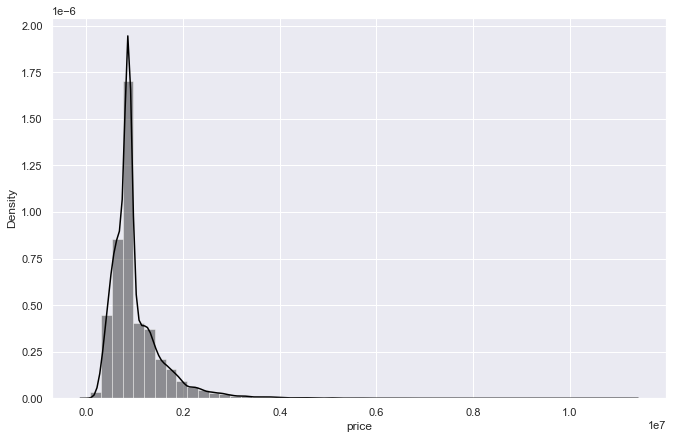

In [11]:
sns.set(rc = {"figure.figsize" : (11, 7)})
sns.distplot(df_train["price"], color = "black");

In [12]:
#need to get rid of class imbalance
df_train["price"] = np.log1p(df_train["price"])
df_train["price"].head(n = 10)

0    13.803439
1    15.473739
2    13.592368
3    14.077876
4    14.013132
5    13.593617
6    13.677398
7    13.815512
8    13.677398
9    13.687678
Name: price, dtype: float64

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

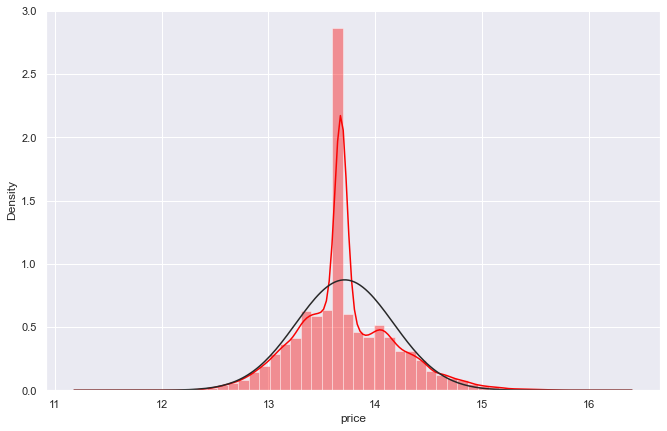

In [13]:
from scipy.stats import norm, skew
sns.distplot(df_train["price"], fit = norm, color = "#FA0303")

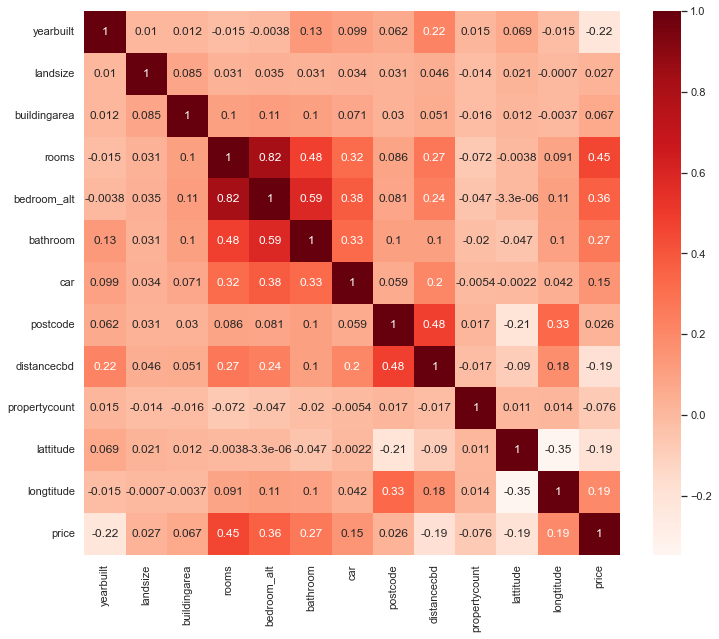

In [14]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [15]:
#corr between bedroom_alt and rooms is high, so we have to drop one of them
df_train.drop('bedroom_alt', axis = 1, inplace = True)

In [16]:
#find the variables that affect the target the most
correlation_df = df_train.corr()
high_correlation_variables = correlation_df.index[abs(correlation_df["price"]) > 0.4]
high_correlation_variables

Index(['rooms', 'price'], dtype='object')

In [17]:
correlation_df["price"]

yearbuilt       -0.220044
landsize         0.026582
buildingarea     0.067282
rooms            0.454933
bathroom         0.268702
car              0.147219
postcode         0.025502
distancecbd     -0.185184
propertycount   -0.076083
lattitude       -0.188732
longtitude       0.191470
price            1.000000
Name: price, dtype: float64

In [18]:
correlation_df["price"][correlation_df["price"].sort_values() > 0.4]

rooms    0.454933
price    1.000000
Name: price, dtype: float64

<AxesSubplot:>

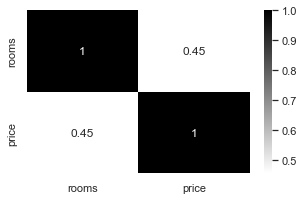

In [19]:
plt.figure(figsize = (5, 3))
sns.heatmap(df_train[high_correlation_variables].corr(), annot = True, cmap = "binary")

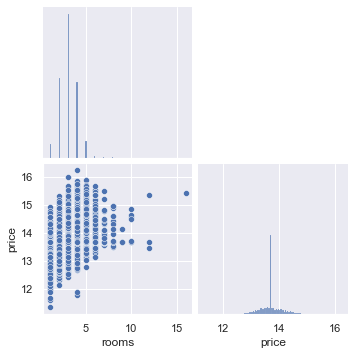

In [20]:
sns.pairplot(df_train[high_correlation_variables], corner = True)

In [21]:
def outlier_detection_train(df, columns):
    rows = []
    will_drop_train = []
    for col in columns:
        #it is required to increase the interquartile range, otherwise too much data is deleted, features distribution are skewed
        Q1 = np.nanpercentile(df[col], 10)
        Q3 = np.nanpercentile(df[col], 99)
        IQR = Q3 - Q1
        outlier_point = 1.5 * IQR
        
        data_out = df[(df[col] < Q1 - outlier_point)|(df[col] > Q3 + outlier_point)]
        rows.extend(data_out.index)
    data_out.head(3)
    #print(rows)
    #print(Counter(rows).items())
    #print(len(Counter(rows).items()))
    
    for r, c in Counter(rows).items():#c - the number of occurrences of the outlier in features
        if c >= 1: will_drop_train.append(r)
    return will_drop_train

In [22]:
will_drop_train = outlier_detection_train(df_train, df_train.select_dtypes(["float", "int"]).columns)
df_without_outl = df_train.drop(will_drop_train, axis = 0)
outl = df_without_outl.iloc[will_drop_train]

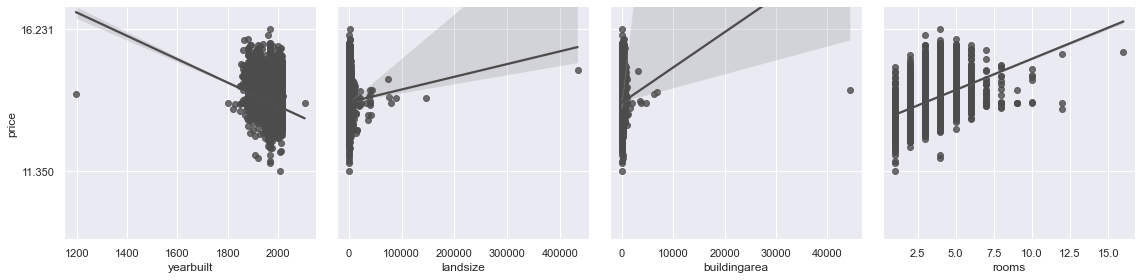

In [22]:
#plots of data with outliers
g = sns.PairGrid(df_train, y_vars=["price"], x_vars=["yearbuilt", "landsize", "buildingarea", "rooms"], height=4)#"bedroom_alt"
g.map(sns.regplot, color=".3")
g.set(ylim=(9, 17), yticks=[11.350418, 16.231424])

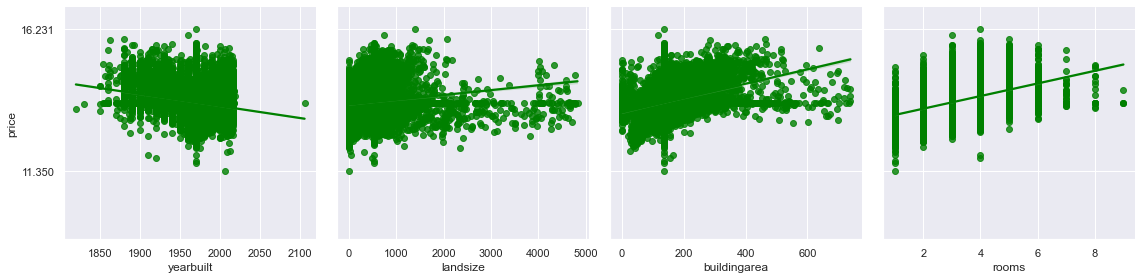

In [23]:
#plots of data without outliers
g = sns.PairGrid(df_without_outl, y_vars=["price"], x_vars=["yearbuilt", "landsize", "buildingarea", "rooms"], height=4)#"bedroom_alt"
g.map(sns.regplot, color="green")
g.set(ylim=(9, 17), yticks=[11.350418, 16.231424])

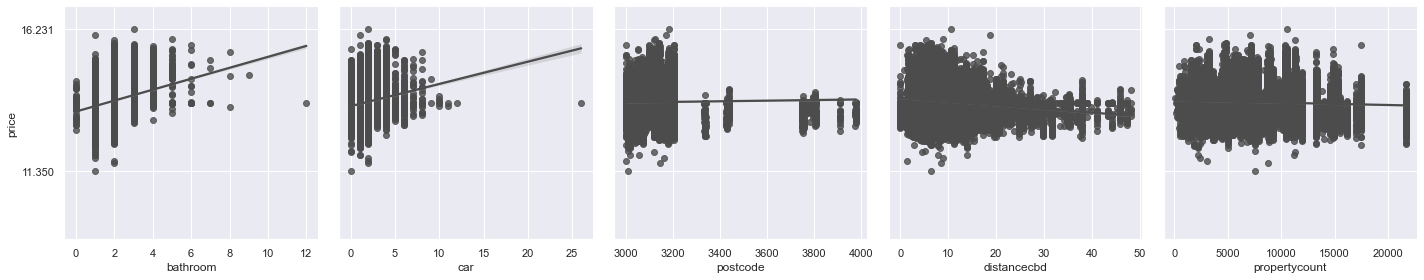

In [24]:
g = sns.PairGrid(df_train, y_vars=["price"], x_vars=["bathroom", "car", "postcode", "distancecbd", "propertycount"], height=4)
g.map(sns.regplot, color=".3")
g.set(ylim=(9, 17), yticks=[11.350418, 16.231424])
#g.set(ylim=(-1, 1.120000e+07), yticks=[8.500000e+04, 1.120000e+07])

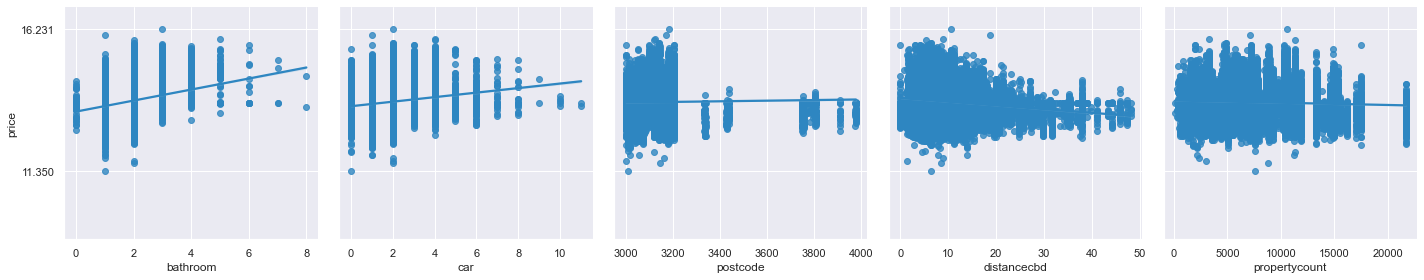

In [25]:
g = sns.PairGrid(df_without_outl, y_vars=["price"], x_vars=["bathroom", "car", "postcode", "distancecbd", "propertycount"], height=4) #
g.map(sns.regplot, color = "#2E86C1")
g.set(ylim=(9, 17), yticks=[11.350418, 16.231424])
#g.set(ylim=(-1, 1.120000e+07), yticks=[8.500000e+04, 1.120000e+07])

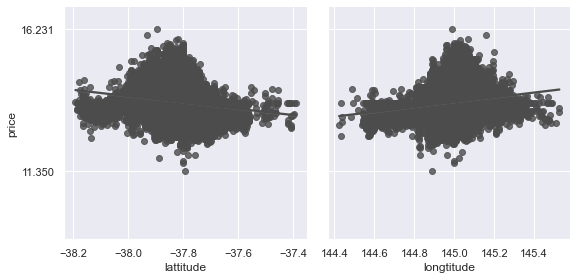

In [26]:
g = sns.PairGrid(df_train, y_vars=["price"], x_vars=["lattitude", "longtitude"], height=4) #
g.map(sns.regplot, color = ".3")
g.set(ylim=(9, 17), yticks=[11.350418, 16.231424])

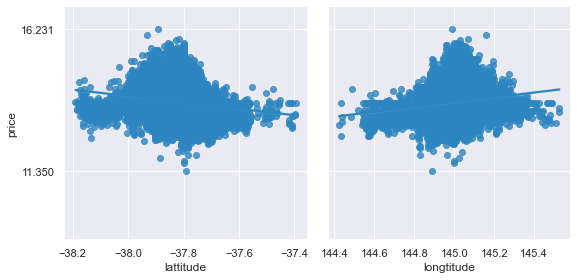

In [27]:
g = sns.PairGrid(df_without_outl, y_vars=["price"], x_vars=["lattitude", "longtitude"], height=4) #
g.map(sns.regplot, color = "#2E86C1")
g.set(ylim=(9, 17), yticks=[11.350418, 16.231424])

In [3]:
import plotly.express as px

fig = px.histogram(df_train, x="yearbuilt", marginal="box")
fig.show()

In [29]:
fig = px.histogram(df_train, x="landsize", marginal="box")
fig.show()

In [30]:
fig = px.histogram(df_without_outl, x="landsize", marginal="box")
fig.show()

In [31]:
landsize_cut = df_train.groupby(pd.cut(df_train["landsize"], np.arange(0, 6000, 1000)))['landsize'].count()
landsize_cut

landsize
(0, 1000]       30815
(1000, 2000]      780
(2000, 3000]      129
(3000, 4000]       52
(4000, 5000]       70
Name: landsize, dtype: int64

In [32]:
landsize_cut.sum()*100/len(df_train["landsize"])

92.69144570247693

In [33]:
outl.describe()

yearbuilt     landsize  buildingarea       rooms    bathroom  \
count   146.000000   146.000000    146.000000  146.000000  146.000000   
mean   1969.273973   549.041096    146.441575    3.082192    1.691781   
std      22.246432   464.074323     58.251965    0.921070    0.557891   
min    1890.000000     0.000000     18.000000    1.000000    1.000000   
25%    1970.000000   403.750000    136.000000    3.000000    1.000000   
50%    1970.000000   521.000000    136.000000    3.000000    2.000000   
75%    1970.000000   645.500000    136.000000    4.000000    2.000000   
max    2017.000000  4096.000000    447.000000    5.000000    3.000000   

              car     postcode  distancecbd  propertycount   lattitude  \
count  146.000000   146.000000   146.000000     146.000000  146.000000   
mean     1.821918  3112.143836    11.508219    7647.356164  -37.803091   
std      0.884229    85.532328     6.898041    4283.197136    0.080303   
min      0.000000  3000.000000     0.000000     938.000000  -38.110140   
25%      1.000000  3056.000000     6.325000    4484.250000  -37.850752   
50%      2.000000  3105.500000    11.200000    6964.000000  -37.800000   
75%      2.000000  3150.000000    15.475000   10331.000000  -37.760475   
max      7.000000  3754.000000    35.400000   21650.000000  -37.571820   

       longtitude       price  
count  146.000000  146.000000  
mean   145.021090   13.736075  
std      0.117230    0.465879  
min    144.561600   12.254868  
25%    144.968277   13.468043  
50%    145.001165   13.677398  
75%    145.081478   14.086864  
max    145.329010   14.771022

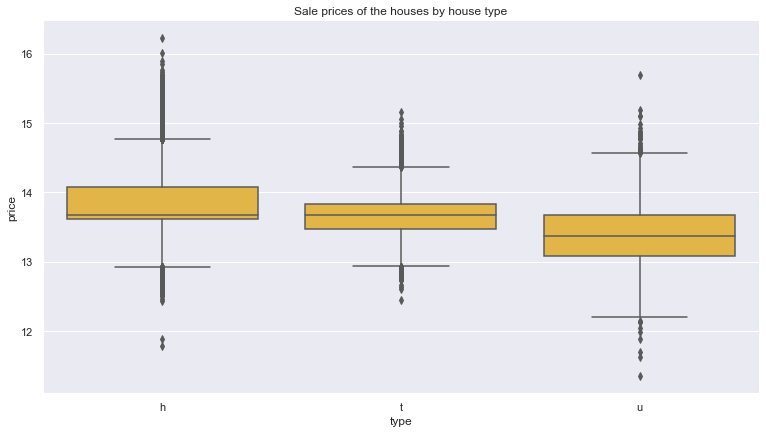

In [34]:
sns.catplot(x = "type",
            y = "price",
            kind = "box",
            height = 6,
            aspect = 1.8,
            color = "#FBC02D",
            data = df_train).set(title = "Sale prices of the houses by house type");

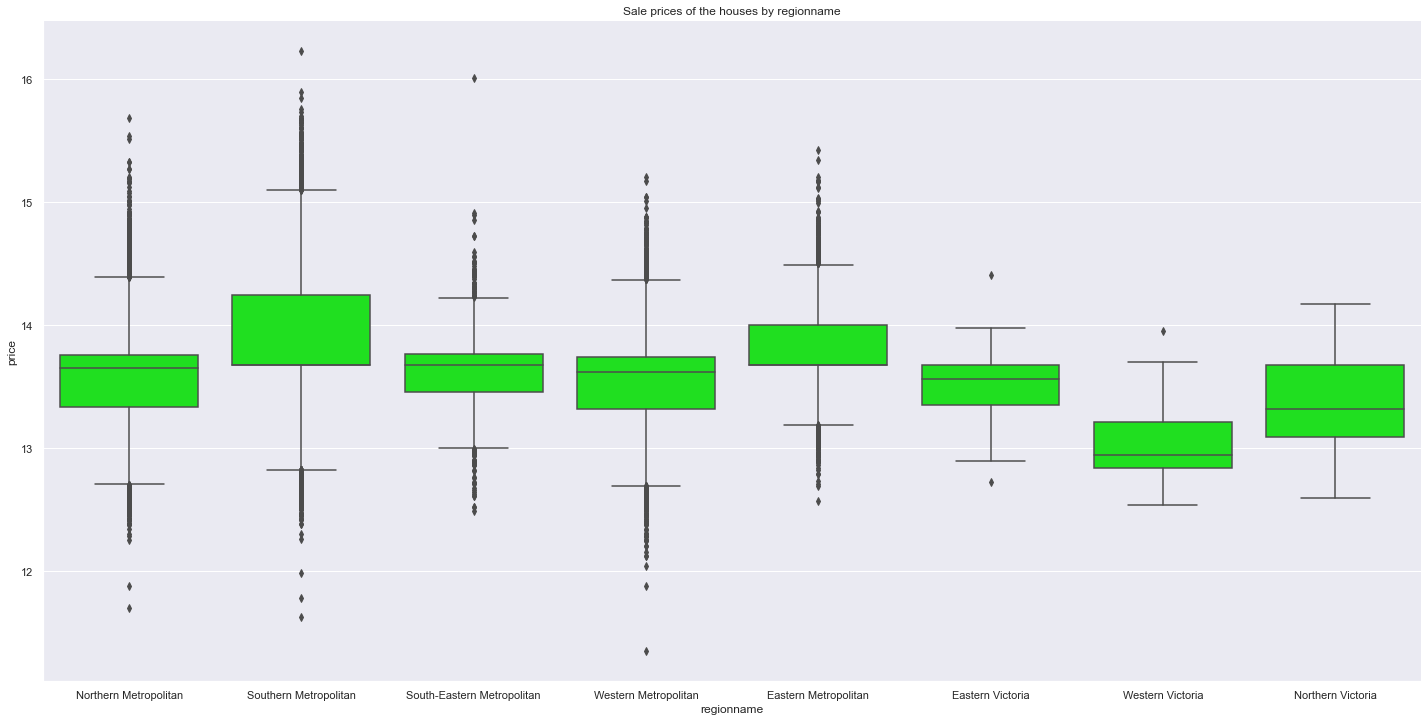

In [35]:
sns.catplot(x = "regionname",
            y = "price",
            kind = "box",
            height = 10,
            aspect = 2,
            color = "#00FF00",
            data = df_train).set(title = "Sale prices of the houses by regionname");

In [36]:
#Encode target labels with value between 0 and n_classes-1.
def Encoder(data):
    data.columns = ["col" + str(i) for i in range(1, data.shape[1] + 1)]
    
    for i in range(1, data.shape[1] + 1):
        if isinstance(data["col" + str(i)][0], str): 
            data["col" + str(i)] = LabelEncoder().fit_transform(data["col" + str(i)])
    return data

In [37]:
df_without_outl = Encoder(df_without_outl)

In [38]:
X = df_without_outl.drop('col17', axis = 1)
y = df_without_outl['col17']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [39]:
#let's start with Linear Refression
X_train_add = sm.add_constant(X_train)

In [40]:
X_train_add = X_train_add.drop(['col12', 'col15'], axis = 1)

In [41]:
model = sm.OLS(y_train, X_train_add).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  col17   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     1540.
Date:                Sun, 10 Jul 2022   Prob (F-statistic):               0.00
Time:                        23:22:44   Log-Likelihood:                -8541.1
No. Observations:               25658   AIC:                         1.711e+04
Df Residuals:                   25643   BIC:                         1.723e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -142.9010      3.409    -41.917      0.0

In [ ]:
#R-squared is low

In [44]:
ypred = model.predict(X_train_add)

# calc rmse
rmse = rmse(y_train, ypred)
rmse

0.3375446484430899

In [45]:
model = sm.OLS(y_train, X_train_add**2).fit()
print(model.summary())
#this model shows even worse results

                            OLS Regression Results                            
Dep. Variable:                  col17   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     1255.
Date:                Sun, 10 Jul 2022   Prob (F-statistic):               0.00
Time:                        23:25:15   Log-Likelihood:                -9674.2
No. Observations:               25658   AIC:                         1.938e+04
Df Residuals:                   25643   BIC:                         1.950e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -60.4778      1.795    -33.699      0.0

In [46]:
#cross-validation
k_fold = KFold(n_splits = 5, random_state = 11, shuffle = True)
def cv_rmse(model, X = X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = k_fold))
    return rmse

In [55]:
#function to calculate metrics
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    
    
    print('Model: {}'.format(model))
    print('MAE: {:0.4f} degrees.'.format(np.mean(errors)))
    #print('MAPE: {}'.format(mape))
    #print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    
    mse = mean_squared_error(test_labels, predictions)
    rmse= mse**.5
    print('RMSE: {}'.format(rmse))
    r2_squared = r2_score(test_labels, predictions)
    print('R2: {}'.format(r2_squared))
    
    
    return accuracy

In [47]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

In [49]:
score = cv_rmse(rf)
print(f'RMSE of {rf} model: {score.mean()}')

RMSE of RandomForestRegressor(n_estimators=500, random_state=42) model: 0.29476524071210974


In [57]:
evaluate(rf, X_test, y_test)

Model: RandomForestRegressor(n_estimators=500, random_state=42)
MAE: 0.2179 degrees.
RMSE: 0.29536875405934826
R2: 0.5724923701162679


98.42075724289786

In [50]:
rf2 = RandomForestRegressor(n_estimators = 1500, max_depth = 9, min_samples_split = 6, min_samples_leaf = 6, random_state = 11)
rf2.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, min_samples_leaf=6, min_samples_split=6,
                      n_estimators=1500, random_state=11)

In [51]:
score2 = cv_rmse(rf2)
print(f'RMSE of {rf2} model: {score2.mean()}')

RMSE of RandomForestRegressor(max_depth=9, min_samples_leaf=6, min_samples_split=6,
                      n_estimators=1500, random_state=11) model: 0.29338972638835237


In [59]:
evaluate(rf2, X_test, y_test)

Model: RandomForestRegressor(max_depth=9, min_samples_leaf=6, min_samples_split=6,
                      n_estimators=1500, random_state=11)
MAE: 0.2252 degrees.
RMSE: 0.2950984132358528
R2: 0.5732745779378127


98.36874796802319

In [52]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
#
# Hyperparameters for GradientBoostingRegressor
#
gbr_params = {'n_estimators': 1000,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'squared_error'}
#
# Create an instance of gradient boosting regressor
#
gbr = GradientBoostingRegressor(**gbr_params)
#
# Fit the model
#
gbr.fit(X_train_std, y_train)

GradientBoostingRegressor(learning_rate=0.01, min_samples_split=5,
                          n_estimators=1000)

In [53]:
print("Model Accuracy: %.3f" % gbr.score(X_test_std, y_test))
#
# Create the mean squared error
#
mse = mean_squared_error(y_test, gbr.predict(X_test_std))
#print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean squared error (RMSE) on test set: {:.4f}".format(mse**0.5))

Model Accuracy: 0.571
The mean squared error (RMSE) on test set: 0.2958


## Dataframe to predict

In [60]:
df_predict = pd.read_csv("./data/predict.csv")
df_predict.head()

id type  yearbuilt  landsize  buildingarea  rooms  bedroom_alt  \
0  11489    h        NaN     570.0           NaN      4          4.0   
1  27476    t        NaN       NaN           NaN      2          NaN   
2  29697    h     2015.0       NaN         155.0      3          3.0   
3  18051    h     1968.0     884.0           NaN      3          3.0   
4  27863    h        NaN       NaN           NaN      3          3.0   

   bathroom  car                  regionname                 councilarea  \
0       1.0  1.0        Eastern Metropolitan        Banyule City Council   
1       NaN  NaN        Western Metropolitan  Moonee Valley City Council   
2       2.0  2.0       Northern Metropolitan     Whittlesea City Council   
3       1.0  1.0  South-Eastern Metropolitan      Frankston City Council   
4       2.0  2.0       Southern Metropolitan     Boroondara City Council   

            suburb          address  postcode  distancecbd  propertycount  \
0       Heidelberg     34 Martin St    3084.0         10.6         2890.0   
1       Ascot Vale    1/35 Union Rd    3032.0          4.3         6567.0   
2           Mernda    23 Monarch Av    3754.0         25.9         5812.0   
3  Frankston South  5 Palmerston Cr    3199.0         38.0         7566.0   
4    Hawthorn East   45 Havelock Rd    3123.0          6.2         6482.0   

   lattitude  longtitude  
0   -37.7523   145.06040  
1        NaN         NaN  
2   -37.6030   145.06892  
3   -38.1632   145.10766  
4   -37.8340   145.05240

In [61]:
df_predict.isna().sum()

id                 0
type               0
yearbuilt        270
landsize         174
buildingarea     303
rooms              0
bedroom_alt      122
bathroom         122
car              128
regionname         0
councilarea        0
suburb             0
address            0
postcode           0
distancecbd        0
propertycount      0
lattitude        121
longtitude       121
dtype: int64

In [62]:
df_predict = df_predict.drop(['id', 'bedroom_alt'], axis = 1)

In [63]:
df_predict.fillna(df_predict.median().round(1), inplace=True)

C:\Users\Admin\AppData\Local\Temp/ipykernel_11064/320133066.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [76]:
def outlier_detection_predict(df, columns):
    rows = []
    will_drop_train = []
    for col in columns:
        Q1 = np.nanpercentile(df[col], 10)
        Q3 = np.nanpercentile(df[col], 96)
        IQR = Q3 - Q1
        outlier_point = 1.5 * IQR
        data_out = df[(df[col] < Q1 - outlier_point)|(df[col] > Q3 + outlier_point)]
        rows.extend(data_out.index)
    data_out.head(3)
    #print(rows)#лист, в котором содержатся индексы оутлаеров, по несколько раз из каждой фичи, там где у всех повторяется, там удаляется строка с датафрейма
    #print(Counter(rows).items())
    #print(len(Counter(rows).items()))
    
    for r, c in Counter(rows).items():
        if c >= 1: will_drop_train.append(r)
    return will_drop_train

In [77]:
will_drop_predict = outlier_detection_predict(df_predict, df_predict.select_dtypes(["float", "int"]).columns)
df_without_outl_predict = df_predict.drop(will_drop_predict, axis = 0)

In [78]:
fig = px.histogram(df_predict, x = "yearbuilt", marginal = "box")
fig.show()

In [79]:
fig = px.histogram(df_predict, x = "landsize", marginal = "box")
fig.show()

In [80]:
fig = px.histogram(df_without_outl_predict, x = "landsize", marginal = "box")
fig.show()

In [81]:
fig = px.histogram(df_predict, x = "buildingarea", marginal = "box")
fig.show()

In [82]:
fig = px.histogram(df_without_outl_predict, x = "buildingarea", marginal = "box")
fig.show()

In [83]:
fig = px.histogram(df_predict, x = "rooms", marginal = "box")
fig.show()

In [84]:
fig = px.histogram(df_predict, x = "bathroom", marginal = "box")
fig.show()

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='car', ylabel='Density'>

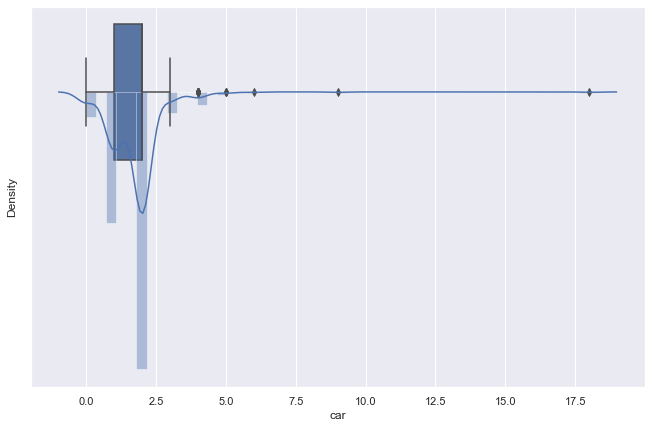

In [85]:
sns.boxplot(df_predict.car)
# Distribution plot
sns.distplot(df_predict.car)

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='car', ylabel='Density'>

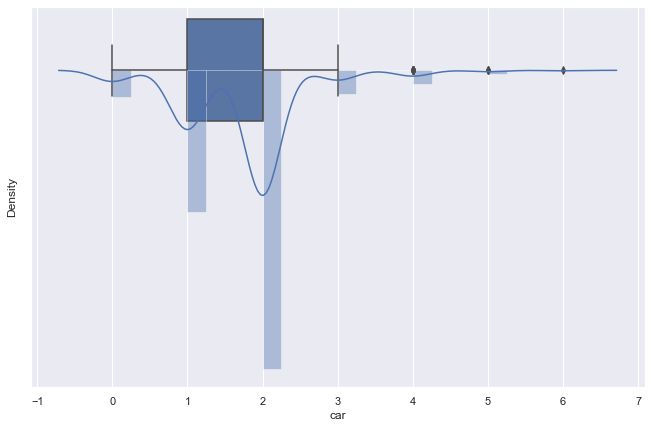

In [86]:
sns.boxplot(df_without_outl_predict.car)
# Distribution plot
sns.distplot(df_without_outl_predict.car)

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='postcode', ylabel='Density'>

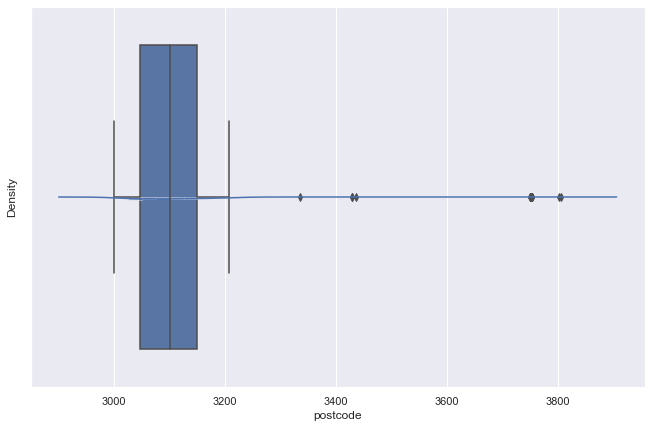

In [87]:
sns.boxplot(df_predict.postcode)
# Distribution plot
sns.distplot(df_predict.postcode)

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='postcode', ylabel='Density'>

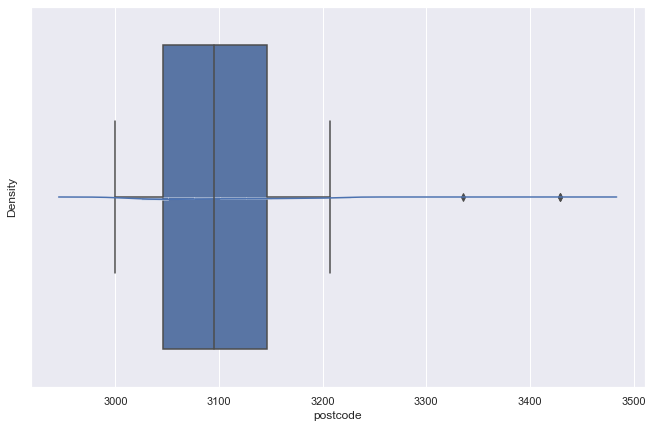

In [88]:
sns.boxplot(df_without_outl_predict.postcode)
# Distribution plot
sns.distplot(df_without_outl_predict.postcode)

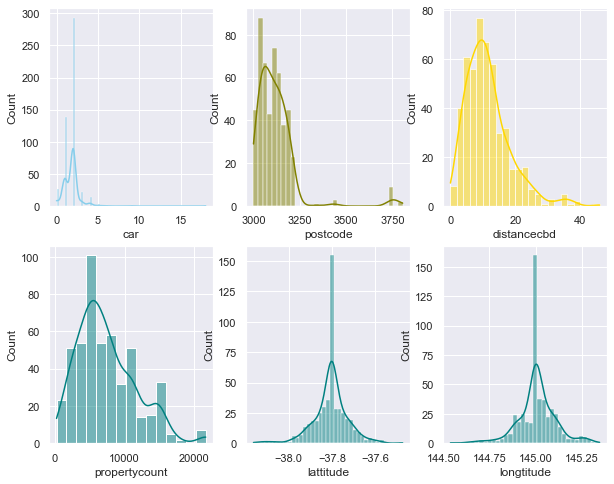

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 3, figsize=(10, 8))

sns.histplot(data=df_predict, x="car", kde=True, color="skyblue", ax=axs[0, 0])#postcode,distancecbd,propertycount,lattitude,longtitude
sns.histplot(data=df_predict, x="postcode", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df_predict, x="distancecbd", kde=True, color="gold", ax=axs[0, 2])
sns.histplot(data=df_predict, x="propertycount", kde=True, color="teal", ax=axs[1, 0])
sns.histplot(data=df_predict, x="lattitude", kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=df_predict, x="longtitude", kde=True, color="teal", ax=axs[1, 2])

plt.show()

In [90]:
postcode_cut = df_predict.groupby(pd.cut(df_predict["postcode"], np.arange(3000, 3900, 200)))['postcode'].count()
postcode_cut

postcode
(3000, 3200]    457
(3200, 3400]     27
(3400, 3600]      3
(3600, 3800]      9
Name: postcode, dtype: int64

In [91]:
df_without_outl_predict.head()

type  yearbuilt  landsize  buildingarea  rooms  bathroom  car  \
0    h     1970.0     570.0         140.0      4       1.0  1.0   
1    t     1970.0     527.5         140.0      2       2.0  2.0   
3    h     1968.0     884.0         140.0      3       1.0  1.0   
4    h     1970.0     527.5         140.0      3       2.0  2.0   
5    u     1970.0     527.5         140.0      1       2.0  2.0   

                   regionname                 councilarea           suburb  \
0        Eastern Metropolitan        Banyule City Council       Heidelberg   
1        Western Metropolitan  Moonee Valley City Council       Ascot Vale   
3  South-Eastern Metropolitan      Frankston City Council  Frankston South   
4       Southern Metropolitan     Boroondara City Council    Hawthorn East   
5       Northern Metropolitan          Yarra City Council         Richmond   

             address  postcode  distancecbd  propertycount  lattitude  \
0       34 Martin St    3084.0         10.6         2890.0   -37.7523   
1      1/35 Union Rd    3032.0          4.3         6567.0   -37.8000   
3    5 Palmerston Cr    3199.0         38.0         7566.0   -38.1632   
4     45 Havelock Rd    3123.0          6.2         6482.0   -37.8340   
5  606/20 Burnley St    3121.0          2.4        14949.0   -37.8000   

   longtitude  
0   145.06040  
1   145.00000  
3   145.10766  
4   145.05240  
5   145.00000

In [92]:
df_without_outl_predict_enc = Encoder(df_without_outl_predict)
sc_pr = StandardScaler()
X_train_std_pr = sc_pr.fit_transform(df_without_outl_predict_enc)

In [93]:
new_pred = gbr.predict(X_train_std_pr)

In [94]:
df_without_outl_predict['pred_price'] = new_pred

In [95]:
df_without_outl_predict.head()

col1    col2   col3   col4  col5  col6  col7  col8  col9  col10  col11  \
0     0  1970.0  570.0  140.0     4   1.0   1.0     0     0     92    286   
1     1  1970.0  527.5  140.0     2   2.0   2.0     5    18      9     28   
3     0  1968.0  884.0  140.0     3   1.0   1.0     3     5     77    359   
4     0  1970.0  527.5  140.0     3   2.0   2.0     4     2     90    340   
5     2  1970.0  527.5  140.0     1   2.0   2.0     2    25    139    408   

    col12  col13    col14    col15      col16  pred_price  
0  3084.0   10.6   2890.0 -37.7523  145.06040   13.864747  
1  3032.0    4.3   6567.0 -37.8000  145.00000   13.647948  
3  3199.0   38.0   7566.0 -38.1632  145.10766   13.528570  
4  3123.0    6.2   6482.0 -37.8340  145.05240   14.148332  
5  3121.0    2.4  14949.0 -37.8000  145.00000   13.225168